In [1]:
import requests
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import json
from src.model_utils import *

In [4]:
# Function to fetch data from the ODB Tide API
def fetch_tide_api_data(lon, lat, start, end):
    base_url = "https://eco.odb.ntu.edu.tw/api/tide"
    params = {
        "lon0": lon,
        "lat0": lat,
        "start": start,
        "end": end,
        "append": "u,v"
    }
    response = requests.get(base_url, params=params)
    return response.json()

# Function to read zarr dataset
def read_zarr_dataset(zarr_path):
    dz = xr.open_zarr(zarr_path, chunks='auto', decode_times=False, consolidated=True)
    print(dz)
    return dz

# Function to extract tide data from zarr dataset
def extract_tide_data_from_zarr(dz, lon, lat, tide_time, variables=['u', 'v']):
    cons = ['q1','o1','p1','k1','n2','m2','s1','s2','k2','m4','ms4','mn4','2n2','mf','mm']
    dsub = dz.sel(lon=lon, lat=lat, method="nearest")
    tide = {}
    for var in variables:
        amp_var = f'{var}_amp'
        ph_var = f'{var}_ph'

        ts = get_tide_series(dsub[amp_var].values, dsub[ph_var].values, cons, tide_time, format="netcdf", unit="", drop_mask=True)
        tide[var] = ts
    return tide

# Function to convert datetime to list
def datetime_to_list(dt):
    return [dt.year, dt.month, dt.day, dt.hour]

# Function to convert calendar dates (dummy implementation)
def convert_calendar_dates(year, month, day, hour):
    return f"{year}-{month:02d}-{day:02d}T{hour:02d}:00:00"

# Function to compare API and zarr data
def compare_tide_data(api_data, zarr_data):
    api_u = np.array(api_data["u"])
    api_v = np.array(api_data["v"])
    print("api_u: ", api_u)
    print("zarr_u: ", zarr_data["u"])
    zarr_u = zarr_data["u"] #.filled(np.nan)
    zarr_v = zarr_data["v"] #.filled(np.nan)
    print("Check length")
    print(len(api_u))
    print(len(zarr_u))
    mag = np.sqrt(api_u**2 + api_v**2)
    print(mag)

    u_diff = np.abs(api_u - zarr_u)
    v_diff = np.abs(api_v - zarr_v)

    return u_diff, v_diff


In [5]:
if True:
    lon, lat = 121.56666529338624, 22.966667575055723 #127.881, 22.472
    start = "2024-08-04T05:30:00.000Z" #"2024-08-01T10:30:00.000Z"
    end = "2024-08-04T10:30:00.000Z"   #"2024-08-04T10:30:00.000Z"
    start_date = datetime.strptime(start, "%Y-%m-%dT%H:%M:%S.%fZ")
    end_date = datetime.strptime(end, "%Y-%m-%dT%H:%M:%S.%fZ")
    
    api_data = fetch_tide_api_data(lon, lat, start, end)
    dz = read_zarr_dataset('../data/tpxo9.zarr')
    tide_time, dtime = get_tide_time(start_date, end_date)
    zarr_data = extract_tide_data_from_zarr(dz, lon, lat, tide_time)

    u_diff, v_diff = compare_tide_data(api_data, zarr_data)

    print("U differences:", u_diff)
    print("V differences:", v_diff)


<xarray.Dataset> Size: 42GB
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 180B 'q1' 'o1' 'p1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 43kB -90.0 -89.97 -89.93 ... 89.93 89.97 90.0
  * lon           (lon) float64 86kB 0.03333 0.06667 0.1 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
a

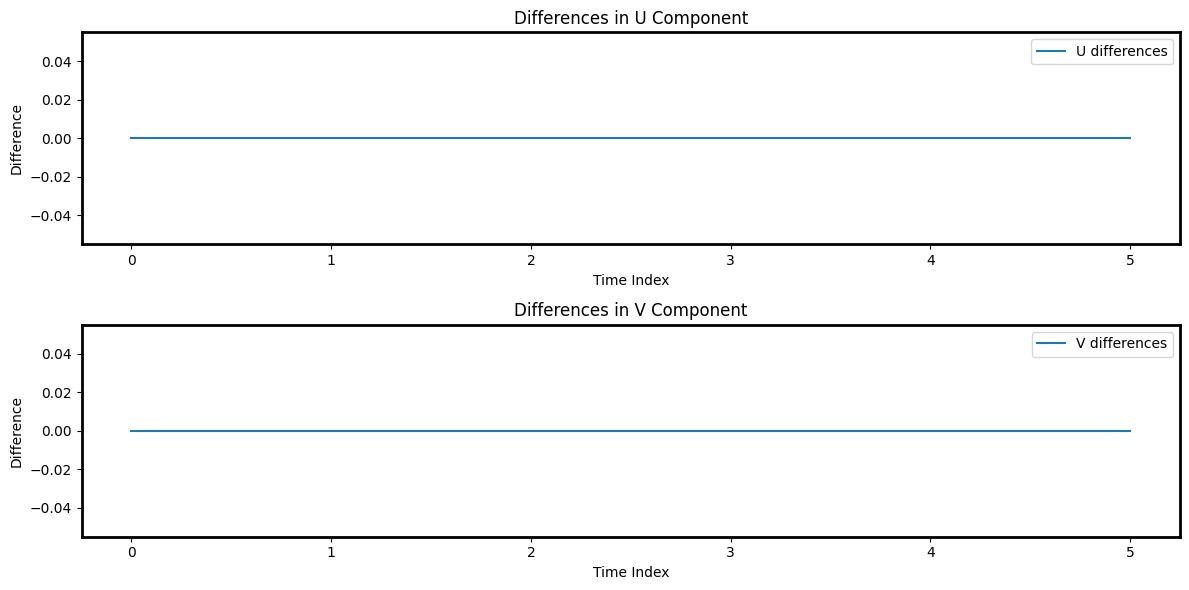

In [6]:
if True:
    # Plotting differences
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(u_diff, label='U differences')
    plt.xlabel('Time Index')
    plt.ylabel('Difference')
    plt.title('Differences in U Component')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(v_diff, label='V differences')
    plt.xlabel('Time Index')
    plt.ylabel('Difference')
    plt.title('Differences in V Component')
    plt.legend()

    plt.tight_layout()
    plt.show()        

In [31]:
#DONT RUN #Reserve the bug-evidence result #The result occur before we find a wrong unit conv using in get_tide_series, so the data enlarge 100 times
if True: # test u, v from get_time_series and get_tide_map 
    grid_sz = 1/30
    lon, lat = 121.56666529338624, 22.966667575055723
    start = "2024-08-04T05:30:00.000Z"
    end = "2024-08-04T10:30:00.000Z"
    start_date = datetime.strptime(start, "%Y-%m-%dT%H:%M:%S.%fZ")
    end_date = datetime.strptime(end, "%Y-%m-%dT%H:%M:%S.%fZ")

    dz = read_zarr_dataset('../data/tpxo9.zarr')
    tide_time, dtime = get_tide_time(start_date, end_date)

    # Compare results from get_tide_series and get_tide_map
    cons = ['q1','o1','p1','k1','n2','m2','s1','s2','k2','m4','ms4','mn4','2n2','mf','mm']
    dsub = dz.sel(lon=lon, lat=lat, method="nearest") 

    ts_u = get_tide_series(dsub['u_amp'].values, dsub['u_ph'].values, cons, tide_time, format="netcdf", unit="cm", drop_mask=True)
    ts_v = get_tide_series(dsub['v_amp'].values, dsub['v_ph'].values, cons, tide_time, format="netcdf", unit="cm", drop_mask=True)

    # get_tide_map for u and v
    dsub2 = dz.sel(lon=slice(lon, lon+grid_sz), lat=slice(lat, lat+grid_sz))
    gtide = get_tide_map(dsub2, tide_time[0:1])

    # Extract first time point from get_tide_map results
    gm_u = gtide['u'][:, :, 0]
    gm_v = gtide['v'][:, :, 0]

    # Print results for comparison
    print("u from get_tide_series:", ts_u)
    print("u from get_tide_map:", gm_u)
    print("v from get_tide_series:", ts_v)
    print("v from get_tide_map:", gm_v)

<xarray.Dataset> Size: 42GB
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 180B 'q1' 'o1' 'p1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 43kB -90.0 -89.97 -89.93 ... 89.93 89.97 90.0
  * lon           (lon) float64 86kB 0.03333 0.06667 0.1 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
u

In [7]:
#After fix the bugs
if True: # test u, v from get_time_series and get_tide_map 
    grid_sz = 1/30
    lon, lat = 121.56666529338624, 22.966667575055723
    start = "2024-08-04T05:30:00.000Z"
    end = "2024-08-04T10:30:00.000Z"
    start_date = datetime.strptime(start, "%Y-%m-%dT%H:%M:%S.%fZ")
    end_date = datetime.strptime(end, "%Y-%m-%dT%H:%M:%S.%fZ")

    dz = read_zarr_dataset('../data/tpxo9.zarr')
    tide_time, dtime = get_tide_time(start_date, end_date)

    # Compare results from get_tide_series and get_tide_map
    cons = ['q1','o1','p1','k1','n2','m2','s1','s2','k2','m4','ms4','mn4','2n2','mf','mm']
    dsub = dz.sel(lon=lon, lat=lat, method="nearest") 

    ts_u = get_tide_series(dsub['u_amp'].values, dsub['u_ph'].values, cons, tide_time, format="netcdf", unit="", drop_mask=True)
    ts_v = get_tide_series(dsub['v_amp'].values, dsub['v_ph'].values, cons, tide_time, format="netcdf", unit="", drop_mask=True)

    # get_tide_map for u and v
    dsub2 = dz.sel(lon=slice(lon, lon+grid_sz), lat=slice(lat, lat+grid_sz))
    gtide = get_tide_map(dsub2, tide_time[0:1])

    # Extract first time point from get_tide_map results
    gm_u = gtide['u'][:, :, 0]
    gm_v = gtide['v'][:, :, 0]

    # Print results for comparison
    print("u from get_tide_series:", ts_u)
    print("u from get_tide_map:", gm_u)
    print("v from get_tide_series:", ts_v)
    print("v from get_tide_map:", gm_v)

<xarray.Dataset> Size: 42GB
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 180B 'q1' 'o1' 'p1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 43kB -90.0 -89.97 -89.93 ... 89.93 89.97 90.0
  * lon           (lon) float64 86kB 0.03333 0.06667 0.1 ... 359.9 360.0 360.0
Data variables:
    u_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_amp         (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
    z_ph          (lat, lon, constituents) float64 7GB dask.array<chunksize=(113, 113, 8), meta=np.ndarray>
u